<a href="https://colab.research.google.com/github/yohanesnuwara/bsc-thesis-carbon-capture-storage/blob/master/main/03_xu_payne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xu-Payne (2009) Modelling for Carbonate Pore Type Characterization

Import basic libraries.

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

Import from my Github repo. 

In [1]:
! git clone https://github.com/yohanesnuwara/bsc-thesis-carbon-capture-storage/

Cloning into 'bsc-thesis-carbon-capture-storage'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 131 (delta 60), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 12.99 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (60/60), done.


Load `DEM_Berryman` function. `DEM_Berryman` is Differential Effective Medium theory by Berryman (1980) used in Xu-Payne to compute P-velocity of carbonate rock that depends on pore geometry. 

In [0]:
import sys
sys.path.append('/content/bsc-thesis-carbon-capture-storage/lib')
import DEM_Berryman
from DEM_Berryman import DEM

According to Xu-Payne (2009), pores in carbonate rocks are composed of three types of pores:


1.   Reference pore
2.   Stiff pore (more spherical than reference pore)
3.   Crack pore (more elongated than reference pore)

![alt text](https://drive.google.com/uc?id=1HkESSk1KEiRCqE3f1vw84ylzfO7wUi7f)

They accepted values of aspect ratio (α) for reference pore = 0.15, crack pore = 0.02, and stiff pore = 0.8. Pore aspect ratio is the ratio between minima and maxima of an ellipsoid pore. 

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTe2pPihOpFDbKguUzM-LcFr8qA933BeU7h6HIIDdMpdtNRoJUw)

The purpose of this modelling is to estimate composition of each pore type in the carbonate rock, in terms of fraction. 

Now, let's import the well log data. The well log data is in LAS format, so we need `lasreader` to read the LAS file. 

In [0]:
import lasreader
log = lasreader.LASReader("/content/bsc-thesis-carbon-capture-storage/data/KTB-01.las", null_subs=np.nan)

And we have lithology marker.

In [0]:
tops = ('Ledok', 'Wonocolo', 'Ngrayong', 'Tawun', 'Kujung')
tops_depths = (275, 340, 1053, 1637, 2777)

In this modelling, we need **sonic velocity** (Vp) and **porosity** (as effective porosity or Ф). In our well data, the sonic velocity is still expressed as **depth-time** (DT). So, convert it first to VP

In [0]:
VP = 1E+06 / log.data['DT'] * 0.3048

Convert the depth, VP, and porosity from the well data into Pandas dataframe.

In [20]:
logfile = pd.DataFrame({"Depth":log.data['DEPT'], "VP":VP, "Porosity":log.data['PHIE']})
logfile

,Depth,VP,Porosity
0,0.00,NaN,NaN
1,10.00,NaN,NaN
2,15.00,NaN,NaN
3,20.00,NaN,NaN
4,25.00,NaN,NaN
...,...,...,...
691,3240.00,4551.531097,0.1863
692,3245.00,4536.504050,0.1936
693,3250.00,4659.703982,0.1692
694,3253.00,4489.634263,0.1555


We only focus on the **carbonate formation**, which Kujung. So, we need to trim the dataframe only in depth range from Top Kujung (2777 m) to the rest. 

In [29]:
topkujung = tops_depths[4]
kujung = logfile[(logfile.Depth >= 2740) & (logfile.Depth <= max(log.data['DEPT']))]
kujung

,Depth,VP,Porosity
591,2740.00,4907.151619,NaN
592,2745.00,3939.688061,0.0001
593,2750.00,3890.449859,0.1565
594,2755.00,3938.939551,0.0001
595,2760.00,4928.033015,0.0001
...,...,...,...
691,3240.00,4551.531097,0.1863
692,3245.00,4536.504050,0.1936
693,3250.00,4659.703982,0.1692
694,3253.00,4489.634263,0.1555


# Xu-Payne

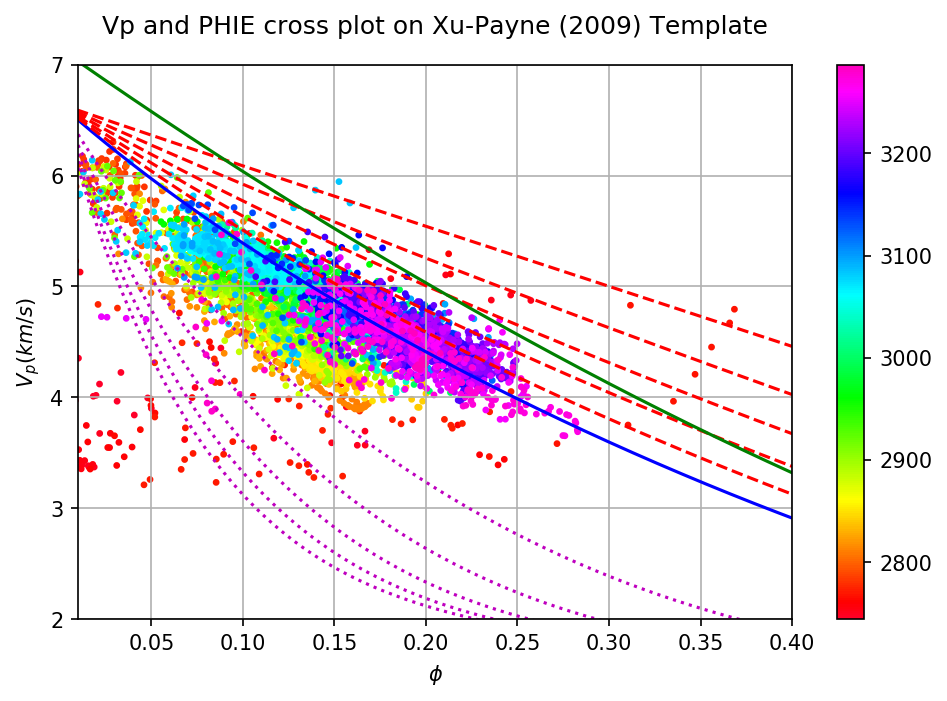

In [34]:
import matplotlib

# matplotlib.use("TkAgg")
import numpy as np
from DEM_Berryman import DEM
import matplotlib.pyplot as plt


def XuPayne():
    """Reproducing Figure 5 of Xu and Payne (2009)"""

    import matplotlib.pyplot as plt
    import Gassmann
    import time

    # Matrix properties
    # Source: Acoustic Properties of Carbonate Rocks p. 77
    Km_dol = 69.0  # GPa
    Gm_dol = 52.0  # GPa
    rhom_dol = 2.88  # g/cm3
    Km_lim = 77.0  # GPa
    Gm_lim = 32.0  # GPa
    rhom_lim = 2.71  # g/cm3

    # Fluid properties
    Kf = 2.24  # GPa, 2.24
    rhof = 0.94  # g/cm3, 0.95

    # Porosity
    phimax = 0.4

    # Aspect ratio of different pore types
    alpha_ref = 0.15
    alpha_crack = 0.02
    alpha_stiff = 0.8

    # Creating lists of inclusion configurations (alpha and volume for each inclusion type)
    crackandref_alphas = []
    crackandref_volumes = []
    stiffandref_alphas = []
    stiffandref_volumes = []
    fractions = [0.2, 0.4, 0.6, 0.8]
    # fractions = [0.1, 0.2, 0.3, 0.4]
    for fraction in fractions:
        crackandref_alphas.append([alpha_crack, alpha_ref])
        crackandref_volumes.append([fraction * phimax, (1.0 - fraction) * phimax])
        stiffandref_alphas.append([alpha_stiff, alpha_ref])
        stiffandref_volumes.append([fraction * phimax, (1.0 - fraction) * phimax])

    alphas = [[alpha_crack]] + crackandref_alphas + [[alpha_ref]] + stiffandref_alphas + [[alpha_stiff]]
    volumes = [[phimax]] + crackandref_volumes + [[phimax]] + stiffandref_volumes + [[phimax]]

    # Adding one extra element for the dolomite line
    alphas += [[alpha_ref]]
    volumes += [[phimax]]

    # Creating lists of matrix proeprties
    Kms = len(alphas) * [Km_lim]
    Gms = len(alphas) * [Gm_lim]
    Kms[-1] = Km_dol
    Gms[-1] = Gm_dol

    # Creating style for each line
    crack_style = 'm:'
    ref_style = 'b-'
    stiff_style = 'r--'
    dol_style = 'g-'

    styles = [crack_style] + [crack_style] * len(crackandref_alphas) + [ref_style] + [stiff_style] + [
        stiff_style] * len(stiffandref_alphas)
    styles += [dol_style]

    # Plot configuration
    plt.figure(figsize=(7.0, 15.4 / 3.0), dpi=150)
    plt.subplots_adjust(left=0.11, top=0.88, bottom=0.16, right=0.96)
    plt.subplot(1, 1, 1)

    for inclusion_alphas, inclusion_volumes, style, Km, Gm in zip(alphas, volumes, styles, Kms, Gms):
        ni = len(inclusion_alphas)

        # Dry inclusions
        Kis = np.zeros(ni, dtype=float)
        Gis = np.zeros(ni, dtype=float)

        K, G, phi = DEM(Km, Gm, Kis, Gis, np.array(inclusion_alphas), np.array(inclusion_volumes))

        rho = (1.0 - phi) * rhom_lim + phi * rhof

        Ks = Gassmann.Ks(K, Km, Kf, phi)

        Vp = np.sqrt((Ks + 4.0 * G / 3.0) / rho)

        plt.plot(phi, Vp, style)

    plt.ylabel("$V_p (km/s)$", fontsize=10)
    plt.xlabel("$\\phi$", fontsize=10)
    plt.ylim(2.0, 7.0)
    plt.xlim(0.0, phimax)

    plt.grid()

    log = np.genfromtxt('/content/bsc-thesis-carbon-capture-storage/data/KTB1_PHIE_Vp.txt')
    depth = log[:, 0]
    phie = log[:, 1]
    vp = log[:, 2] * 0.001 #convert m/s to km/s

    # depth = kujung.Depth
    # phie = kujung.Porosity
    # vp = kujung.VP * 0.001 #convert m/s to km/s

    plt.scatter(phie, vp, c=depth, s=5, cmap='gist_rainbow')
    plt.colorbar()
    plt.title('Vp and PHIE cross plot on Xu-Payne (2009) Template', pad=15)
    plt.xlim(0.01, 0.4)

    plt.show()
    # plt.savefig("exampleXuPayne2009.png", dpi=150)


if __name__ == '__main__':
    XuPayne()